## Starter notebook for MLP ansatz for Helium

1. Energy - using Hessian,
2. Gradients - using known formula (update manually),
3. Optimization - ADAM.

First, non-symmetric, without Jastrow factor, to slowly add complexity

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch import vmap
from functorch import make_functional, vmap, grad
import matplotlib.pyplot as plt
from nn import model, psi_nn

### Model definition

In [2]:
device = torch.device('cuda')
cpu = torch.device('cpu')

### Metropolis sampling

In [3]:
def metropolis(N: int, n_runs: int, model):  
    
    L = 0.5
    
    r1 = torch.rand(n_runs, 3)
    r2 = torch.rand(n_runs, 3)

    sampled_Xs = []
    accept_count = 0

    for _ in tqdm(range(N)):
        chose = torch.rand(n_runs, 1)

        perturbed_r1 = r1 + L * torch.randn(n_runs, 3)
        perturbed_r2 = r2 + L * torch.randn(n_runs, 3)

        r1_trial = torch.where(chose < 0.5, perturbed_r1, r1)
        r2_trial = torch.where(chose >= 0.5, perturbed_r2, r2)

        x_old = torch.cat((r1, r2), dim=1)
        x_trial = torch.cat((r1_trial, r2_trial), dim=1)

        psi_val = psi_nn(x_old, model, return_log=True)
        psi_trial_val = psi_nn(x_trial, model, return_log=True)

        #psi_ratio = (psi_trial_val / psi_val) ** 2
        psi_ratio = torch.exp(2 * (psi_trial_val - psi_val)) 

        rand_uniform = torch.rand(n_runs)

        accepted = psi_ratio > rand_uniform
        accept_count += accepted.sum().item()

        mask = accepted.unsqueeze(1)

        r1 = torch.where(mask, r1_trial, r1)
        r2 = torch.where(mask, r2_trial, r2)

        sampled_Xs.append(torch.cat((r1, r2), dim=1))

    acceptance_ratio = accept_count / (N * n_runs)
    print(f"Acceptance ratio: {acceptance_ratio:.4f}")

    return torch.stack(sampled_Xs)


### Local energy

In [4]:


def local_energy(positions, model):
    positions = positions.clone().detach().requires_grad_(True)

    # Split into r1, r2 vectors
    r1_vec = positions[:, 0:3]
    r2_vec = positions[:, 3:6]

    # Scalar distances
    r1 = torch.norm(r1_vec, dim=1, keepdim=True)
    r2 = torch.norm(r2_vec, dim=1, keepdim=True)
    r12 = torch.norm(r1_vec - r2_vec, dim=1, keepdim=True)

    # Prepare input for NN
    scalar_features = torch.cat([r1, r2, r12], dim=1)

    # Evaluate log ψ
    log_psi_val = psi_nn(positions, model, return_log=False)

    # Gradient ∇ log(ψ)
    grad_log_psi = torch.autograd.grad(log_psi_val.sum(), positions, create_graph=True)[0]
    grad_norm_sq = (grad_log_psi ** 2).sum(dim=1)

    # Laplacian ∇² log(ψ)
    laplacian = torch.zeros_like(log_psi_val)
    for i in range(positions.shape[1]):
        grad_i = grad_log_psi[:, i]
        grad2_i = torch.autograd.grad(
            grad_i.sum(), positions, create_graph=True
        )[0][:, i]
        laplacian += grad2_i

    kinetic = -0.5 * (laplacian/log_psi_val)

    # Potential energy: -2/r1 -2/r2 + 1/r12
    eps = 1e-8  # avoid div by 0
    potential = -2 / (r1.squeeze() + eps) - 2 / (r2.squeeze() + eps) + 1 / (r12.squeeze() + eps)

    return kinetic + potential


def get_local_energy(sampled_Xs, model):

    mc_steps = sampled_Xs.shape[0]
    walkers = sampled_Xs.shape[1]
    reshaped_Xs = sampled_Xs.permute(1, 0, 2) # N_walkers, N, input_dim
    flattened_Xs = reshaped_Xs.flatten(end_dim=1) # N_walkers * N, input_dim
    local_E = local_energy(flattened_Xs, model) # N_walkers * N, 1
    return local_E.reshape(walkers, mc_steps)
 

### Gradients

In [5]:

def parameter_gradients(x, E, model, n_walkers, mc_steps):
    
    fmodel, params = make_functional(model)

    def psi_func(params, x):
        return fmodel(params, x.unsqueeze(0)).squeeze()

    grad_log_psi = grad(psi_func)

    grads = vmap(grad_log_psi, in_dims=(None, 0))(params, x)
    flat_grads = torch.cat([g.reshape(x.shape[0], -1) for g in grads], dim=1)

    n_parameters = flat_grads.shape[-1]
    
    #psi_val = psi(x, model).unsqueeze(1).repeat(1, n_parameters)
    
    #flat_grads = flat_grads / psi_val


    #mean_grad = torch.mean(flat_grads, axis=0)
    E = E.flatten()
    mean_E = torch.mean(E)

    centered_E = E - mean_E
    centered_grads = flat_grads # - mean_grad.unsqueeze(0).repeat(mc_steps, 1)

    grads = torch.mean(centered_grads.T * centered_E, axis=1)

    
    return grads.reshape(n_parameters, 1)

def get_parameter_gradients(sampled_Xs, local_E, model):

    mc_steps = sampled_Xs.shape[0]
    n_walkers = sampled_Xs.shape[1]
    reshaped_Xs = sampled_Xs.permute(1, 0, 2) # N_walkers, N, input_dim
    flattened_Xs = reshaped_Xs.flatten(end_dim=1) # N_walkers * N, input_dim

    return parameter_gradients(flattened_Xs, local_E, model, n_walkers, mc_steps)


### Assigning gradients to model

In [6]:
def assign_gradients_to_model(parameter_gradients, model):
    """Assign a flattened gradient vector to model parameters."""
    pointer = 0
    for p in model.parameters():
        numel = p.numel()
        p.grad = parameter_gradients[pointer:pointer + numel].view_as(p).clone()
        pointer += numel

    return

### Utils

In [7]:
def running_average(tensor, window_size=None):
    cumsum = torch.cumsum(tensor, dim=0)
    if window_size is None:
        # For the full running average (over all elements)
        return cumsum / torch.arange(1, len(tensor) + 1, device=tensor.device, dtype=torch.float32)
    else:
        # For a moving average with a fixed window size
        window = torch.ones(window_size, device=tensor.device)
        conv = torch.conv1d(tensor.unsqueeze(0).unsqueeze(0), window.unsqueeze(0).unsqueeze(0), padding=window_size//2)
        return conv.squeeze(0).squeeze(0)
    
def get_variances(E):
    # Variance in random walkers mean energy
    random_walker_variance = torch.mean((torch.mean(E.to(cpu), axis=1) - torch.mean(E)) ** 2)
    # Mean along the sample dimension (dim=1)
    mean_E_trial = E.mean(dim=1)                 # shape: (n_trials,)

    # Broadcasting: subtract column‑wise, then average again along dim=1
    var_E_trial  = torch.mean(((E - mean_E_trial[:, None]) ** 2).mean(dim=1))

    return random_walker_variance, var_E_trial

In [ ]:
sampled_Xs.shape

r1 = torch.norm(sampled_Xs[:, :, :3], dim=2, keepdim=True)
r2 = torch.norm(sampled_Xs[:, :, 3:], dim=2, keepdim=True)
r12 = torch.norm(sampled_Xs[:, :, :3] - sampled_Xs[:, :, 3:], dim=2, keepdim=True)
torch.cat([r1, r2, r12], dim=2).shape

In [24]:
torch.cat([r1, r2, r12], dim=2).shape

torch.Size([4500, 20, 3])

In [21]:
r1.shape

torch.Size([4500, 20, 1])

In [31]:
grads = get_parameter_gradients(grad_Xs, local_E, model)

AttributeError: 'torch.Size' object has no attribute 'shape'

### Training loop

In [ ]:
plt.plot(energies)

In [ ]:

energies = []
optimizer = torch.optim.Adam(model.parameters())

for i in range(100):
    N = 5000
    n_walkers = 20

    sampled_Xs = metropolis(N, n_walkers, model.to(cpu))[500:]

    local_E = get_local_energy(
        sampled_Xs, model)
    print(f"Mean energy is {torch.mean(local_E)}")
    energies.append(torch.mean(local_E))

    r1 = torch.norm(sampled_Xs[:, :, :3], dim=2, keepdim=True)
    r2 = torch.norm(sampled_Xs[:, :, 3:], dim=2, keepdim=True)
    r12 = torch.norm(sampled_Xs[:, :, :3] - sampled_Xs[:, :, 3:], dim=2, keepdim=True)
    grad_Xs = torch.cat([r1, r2, r12], dim=2)

    grads = get_parameter_gradients(grad_Xs, local_E, model)

    #print(grads.shape)
    assign_gradients_to_model(grads, model)

    optimizer.step()  # apply gradients
    torch.cuda.empty_cache()

    


In [17]:
running_avg = running_average(local_E[0], 200)

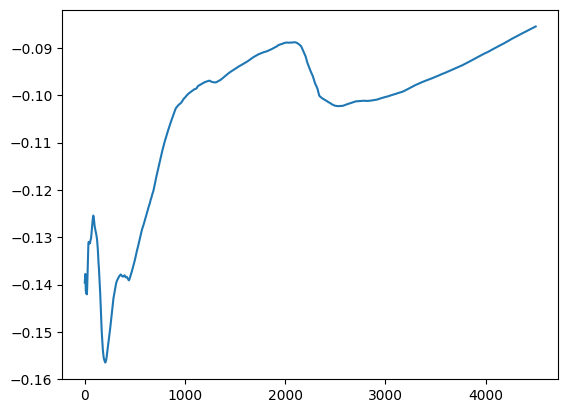

In [18]:
plt.plot(running_average(local_E[0].detach()))

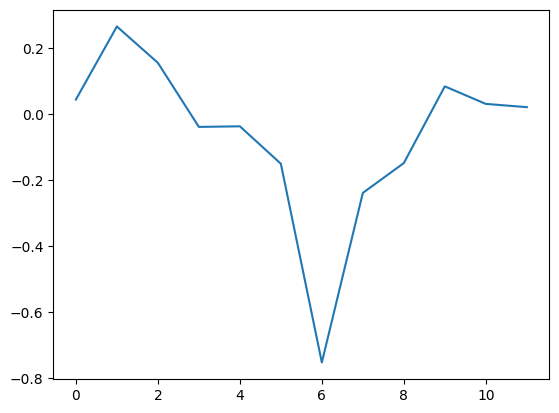

In [77]:
plt.plot(torch.stack(energies).detach())

Incoporate skipping the first n steps in local energy and gradient calulations